In [1]:
from collections import OrderedDict
import copy
import time
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from orderbook_utils import convert_orderbook, plot_orderbooks

## Single price point: appropriate data structure

In [2]:
class PricePoint:
    """
    Implements functionality for a single price point. 
    
    Orders at a price point are stored in an ordered doubly 
    linked dictionary. This permits quick O(1) removal of entries 
    from the start of the dict, as well as efficient cancellation 
    by order ID. 
    """
    
    def __init__(self, price):
        self.price = price
        self.orders = OrderedDict()
        
    def add_order(self, oid, qty, tid, oid2price):
        """
        Add a new order at the end of the order dictionary.
        
        Args
        ----
        oid: int
            Integer order ID.
        qty: int
            Order quantity.
        tid: int
            Trader ID.
        oid2price: dict
            Hash map to link IDs to price points (to be updated).
        """
        self.orders[oid] = {'qty':qty,'tid':tid}
        oid2price[oid] = self.price
            
    def remove_oldest_order(self, oid2price):
        """
        Remove the first (oldest) order.
        """
        if self.orders:
            (oid,_) = self.orders.popitem(last=False)
            del oid2price[oid]
            
    def cancel_order(self, oid, qty, oid2price):
        """
        Cancel or modify an order using its ID.
        """
        if oid in self.orders:
            if qty < self.orders[oid]['qty'] and qty>0:
                self.orders[oid]['qty'] = qty
            elif qty==0:
                del self.orders[oid]
                del oid2price[oid]
            else:
                raise ValueError(
                    ('Error in cancel_order: '+
                     'qty={} of order={} cannot be changed to '+
                     'requested qty={}')
                    .format(self.orders[oid]['qty'], oid, qty)
                    )
        else:
            raise KeyError('Error in cancel_order: '+
                           f'no order={oid} at price={self.price}')
            
    def cancel_order_no_checks(self, oid, qty, oid2price):
        """
        Skip checks (can be done by the exchange)
        """  
        if qty != 0:
            self.orders[oid]['qty'] = qty
        else:
            del self.orders[oid]
            del oid2price[oid]

## PricePoint tests 

In [3]:
oid2price = dict()
prices=[12,22]
pp1 = PricePoint(prices[0])
pp1.add_order(oid=0, qty=5, tid=1, oid2price=oid2price)
pp1.add_order(oid=1, qty=15, tid=1, oid2price=oid2price)
pp1.add_order(oid=2, qty=25, tid=2, oid2price=oid2price)
pp1.remove_oldest_order(oid2price=oid2price)

pp2 = PricePoint(prices[1])
pp2.add_order(oid=3, qty=30, tid=5, oid2price=oid2price)
pp2.add_order(oid=4, qty=35, tid=8, oid2price=oid2price)
pp2.add_order(oid=5, qty=40, tid=9, oid2price=oid2price)
pp2.add_order(oid=6, qty=45, tid=9, oid2price=oid2price)
pp2.cancel_order(oid=4, qty=7, oid2price=oid2price)
pp2.cancel_order(oid=5, qty=0, oid2price=oid2price)

print('orders at price={}:'.format(prices[0]))
for item in pp1.orders.items(): print(item)
print('\norders at price={}:'.format(prices[1]))
for item in pp2.orders.items(): print(item)
print('\nID to price point:')
for item in oid2price.items(): print(item)
    
print('\ntest for invalid requests:')
try:
    pp2.cancel_order(33, qty=7, oid2price=oid2price)
except KeyError as err:
    print(err)
try:
    pp2.cancel_order(4, qty=100, oid2price=oid2price)
except ValueError as err:
    print(err)  

orders at price=12:
(1, {'qty': 15, 'tid': 1})
(2, {'qty': 25, 'tid': 2})

orders at price=22:
(3, {'qty': 30, 'tid': 5})
(4, {'qty': 7, 'tid': 8})
(6, {'qty': 45, 'tid': 9})

ID to price point:
(1, 12)
(2, 12)
(3, 22)
(4, 22)
(6, 22)

test for invalid requests:
'Error in cancel_order: no order=33 at price=22'
Error in cancel_order: qty=7 of order=4 cannot be changed to requested qty=100


## Exchange: order posting and matching

In [4]:
import copy

class Exchange:
    """
    Implements order management and messaging to traders.
    """
    
    def __init__(self, min_price=4032, max_price=6032, log_file='log.csv'):
        """        
        Args
        ----
        min_price: int
            minimum valid price in cents
        max_price: int
            maximum valid price in cents
        log_file: str
            file used for logging
        """
        
        # set allowed price limits in cents
        self.min_price=min_price
        self.max_price=max_price
        
        # initialize all available price points
        self.price_points=[]
        for price in range(self.min_price, self.max_price+1):
            self.price_points.append(PricePoint(price))
        # hash map to link all order IDs to their price points
        self.oid2price = dict()
        # python dicts are doubly-linked -> O(1) removal/addition of elements
            
        # set initial min/max price points as array indices
        self.sell_min_ind = self.max_price-self.min_price+1
        self.buy_max_ind = -1
                    
        # current order ID
        self.oid = 0
        # current fill ID
        self.fid = 0
        
        self.time = 0
        self.log_file = log_file
        
    def execute_order_add(self, tid, side, price, qty):
        """
        Fill an incoming order, post it to the orderbook 
        if not fully filled. Write logs of relevant messages. 
        
        Args
        ----
        tid: int
            Trader ID
        side: str
            buy or sell
        price: int 
            Order price point in cents
        qty: int
            Order quantity
            
        Returns
        -------
        (oid, fill_msgs): tuple
        oid : int
            ID of the processed order, return -1 if order has been declined
        fill_msgs: list of dict
            list of fill messages for traders
        """
        
        # log OrderAdd message
        self.__log_add(tid,side,price,qty)
        
        # check if order price is valid
        if price < self.min_price or price > self.max_price:
            print(f'Order by trader={tid} at time={self.time} declined: '+
                  f'price={price} is outside allowed limits')
            return (-1,[])
        
        # log OrderAcknowledgement message
        self.__log_ackn(self.oid)
        fill_msgs = []
        # convert price to indices
        p = price-self.min_price
        qty_left = qty

        if side=='buy':
            
            # first try to fill the order immediately without 
            # posting it to the orderbook 

            while p>=self.sell_min_ind:

                ppoint = self.price_points[self.sell_min_ind]
                while len(ppoint.orders)>0:
                    pp_oid = list(ppoint.orders.keys())[0]
                    pp_order = list(ppoint.orders.values())[0]

                    if qty_left <= pp_order['qty']:

                        # generate and log fill message for seller
                        fill_msgs.append(self.__log_fill(pp_oid, qty_left))
                        # generate and log full fill message for buyer
                        fill_msgs.append(self.__log_fill(self.oid, qty))
                        ppoint.orders[pp_oid]['qty'] -= qty_left
                        if ppoint.orders[pp_oid]['qty']==0:
                            ppoint.remove_oldest_order(self.oid2price)
                        self.oid += 1
                        return (self.oid-1, fill_msgs)

                    elif qty_left > pp_order['qty']:

                        # generate and log full fill message for seller
                        fill_msgs.append(self.__log_fill(pp_oid, pp_order['qty']))
                        qty_left -= pp_order['qty']
                        ppoint.orders[pp_oid]['qty'] = 0
                        ppoint.remove_oldest_order(self.oid2price)
                            
                self.sell_min_ind += 1
                
            # generate partial fill message for buyer
            if qty_left<qty:
                fill_msgs.append(self.__log_fill(self.oid, qty-qty_left))

            # order cannot be fully filled at the moment
            # -> add it to the orderbook
            self.price_points[p].add_order(self.oid, qty_left, 
                                           tid, self.oid2price)         
            if p>self.buy_max_ind:
                self.buy_max_ind = p
            self.oid += 1
            return (self.oid-1, fill_msgs)
            
        elif side=='sell':
            
            # first try to fill the order immediately without 
            # posting it to the orderbook 

            while p<=self.buy_max_ind:

                ppoint = self.price_points[self.buy_max_ind]
                while len(ppoint.orders)>0:
                    pp_oid = list(ppoint.orders.keys())[0]
                    pp_order = list(ppoint.orders.values())[0]

                    if qty_left <= pp_order['qty']:

                        # generate and log fill message for buyer
                        fill_msgs.append(self.__log_fill(pp_oid, qty_left))
                        # generate and log full fill message for seller
                        fill_msgs.append(self.__log_fill(self.oid, qty))
                        
                        ppoint.orders[pp_oid]['qty'] -= qty_left
                        if ppoint.orders[pp_oid]['qty']==0:
                            ppoint.remove_oldest_order(self.oid2price)

                        self.oid += 1
                        return (self.oid-1, fill_msgs)

                    elif qty_left > pp_order['qty']:

                        # generate and log full fill message for buyer
                        fill_msgs.append(self.__log_fill(pp_oid, pp_order['qty']))
                        qty_left -= pp_order['qty']
                        ppoint.orders[pp_oid]['qty'] = 0   
                        ppoint.remove_oldest_order(self.oid2price)

                self.buy_max_ind -= 1
                
            # generate partial fill message for seller
            if qty_left<qty:
                fill_msgs.append(self.__log_fill(self.oid, qty-qty_left))

            # order cannot be fully filled at the moment 
            # -> add it to the orderbook
            self.price_points[p].add_order(self.oid, qty_left, 
                                           tid, self.oid2price)       
            if p<self.sell_min_ind:
                self.sell_min_ind = p
            self.oid += 1
            return (self.oid-1, fill_msgs)
        
    def execute_order_cancel(self, oid, qty):
        """
        Cancel order by ID [oid] or change its quantity to [qty].
        """
        if oid in self.oid2price:
            # get price point index using hash table
            p = self.oid2price[oid] - self.min_price
            ppoint = self.price_points[p]
            if qty < ppoint.orders[oid]['qty'] and qty>=0:
                # check if it's the last inside order in ppoint 
                if qty==0 and len(ppoint.orders)==1:
                    if p==self.buy_max_ind:
                        self.buy_max_ind -= 1
                    if p==self.sell_min_ind:
                        self.sell_min_ind += 1
                # cancel
                ppoint.cancel_order_no_checks(
                    oid, qty, self.oid2price)
                 
                # log OrderCancel message
                self.__log_cancel(oid,qty)
                return (oid,[])
            else:
                print(f'Request to cancel order={oid} declined: '+
                      f'qty={qty} is invalid')
                return (-1,[])
        else:
            print(f'Request to cancel order={oid} declined: '+
                    f'order not found')
            return (-1,[])
            
    def __enter__(self):
        self.log = open(self.log_file, 'w')
        self.log.write('time,msg,oid,tid,fid,side,price,qty\n') 
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.log.close()
        
    def __log_add(self, tid, side, price, qty):
        self.log.write(f'{self.time},add, ,{tid}, ,{side},{price},{qty}\n') 
        return {'time':self.time, 'tid':tid, 'side':side, 'price':price, 'qty':qty}

    def __log_ackn(self, oid):
        self.log.write(f'{self.time},ackn,{oid}, , , , , \n')
        return {'time':self.time, 'oid':oid}

    def __log_fill(self, oid, qty):
        self.log.write(f'{self.time},fill,{oid}, ,{self.fid}, , ,{qty}\n')     
        self.fid += 1
        return {'time':self.time, 'oid':oid, 'fid':self.fid-1, 'qty':qty}
        
    def __log_cancel(self, oid, qty):
        self.log.write(f'{self.time},cancel,{oid}, , , , ,{qty}\n') 
        return {'time':self.time, 'oid':oid, 'qty':qty}

## Exchange tests

Request to cancel order=7 declined: qty=10 is invalid


/Users/jonjon/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/jonjon/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


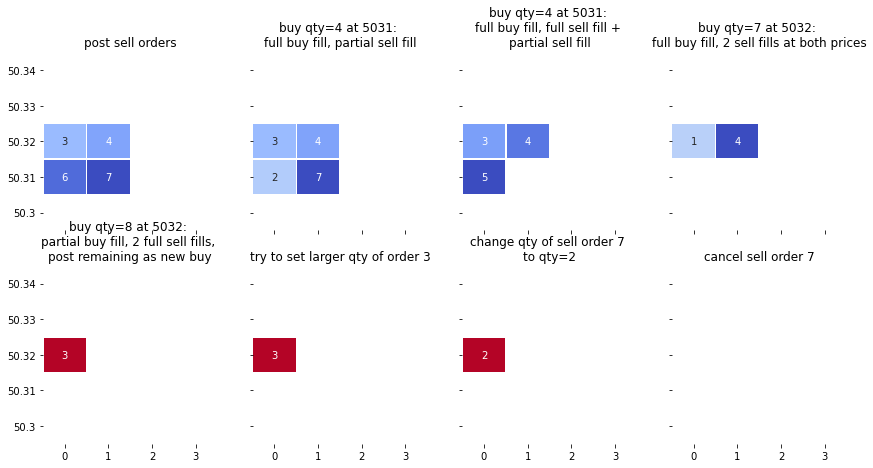

In [5]:
# Place some orders

ob_n_prices = 4
ob_n_orders = 4
ob_mid_price = 5032

price1=5031
price2=5032

orderbooks = []

with Exchange(4032,6032) as ex:
    
    ob_convert_kwargs = dict(ex=ex, 
                         n_prices=ob_n_prices, 
                         n_orders=ob_n_orders,
                         mid_price=ob_mid_price
                         ) 
    steps=[]

    steps.append('post sell orders')
    for qty in [6,7]:
        ex.execute_order_add(tid=0, side='sell', price=price1, qty=qty)
    for qty in [3,4]:
        ex.execute_order_add(tid=0, side='sell', price=price2, qty=qty)
    orderbooks.append(convert_orderbook(**ob_convert_kwargs))

    steps.append(f'buy qty=4 at {price1}: \nfull buy fill, partial sell fill')
    ex.execute_order_add(tid=0, side='buy', price=price1, qty=4)
    orderbooks.append(convert_orderbook(**ob_convert_kwargs))

    steps.append(f'buy qty=4 at {price1}: \nfull buy fill, full sell fill '+
                 '+ \npartial sell fill') 
    ex.execute_order_add(tid=0, side='buy', price=price1, qty=4)
    orderbooks.append(convert_orderbook(**ob_convert_kwargs))

    steps.append(f'buy qty=7 at {price2}: \nfull buy fill, '+
                 '2 sell fills at both prices') 
    ex.execute_order_add(tid=0, side='buy', price=price2, qty=7)
    orderbooks.append(convert_orderbook(**ob_convert_kwargs))
        
    steps.append(f'buy qty=8 at {price2}: \npartial buy fill, 2 full sell fills, \n'+
          'post remaining as new buy') 
    ex.execute_order_add(tid=0, side='buy', price=price2, qty=8)
    orderbooks.append(convert_orderbook(**ob_convert_kwargs))
    
    steps.append('try to set larger qty of order 3') 
    ex.execute_order_cancel(oid=7, qty=10)
    orderbooks.append(convert_orderbook(**ob_convert_kwargs))

    steps.append('change qty of sell order 7 \nto qty=2') 
    ex.execute_order_cancel(oid=7, qty=2)
    orderbooks.append(convert_orderbook(**ob_convert_kwargs))
        
    steps.append('cancel sell order 7') 
    ex.execute_order_cancel(oid=7, qty=0)
    orderbooks.append(convert_orderbook(**ob_convert_kwargs))
    
plot_orderbooks(orderbooks, sx=4,sy=2, figscale=0.9, titles=steps, 
                hm_kwargs=dict(linewidths=0.4, annot=True, cbar=False))

### Check logs

In [6]:
log = pd.read_csv('log.csv')
display(log)

,time,msg,oid,tid,fid,side,price,qty
0,0,add,,0,,sell,5031,6
1,0,ackn,0,,,,,
2,0,add,,0,,sell,5031,7
3,0,ackn,1,,,,,
4,0,add,,0,,sell,5032,3
5,0,ackn,2,,,,,
6,0,add,,0,,sell,5032,4
7,0,ackn,3,,,,,
8,0,add,,0,,buy,5031,4
9,0,ackn,4,,,,,


## Trader Class

In [7]:
class Trader:
    """
    Implements functionality for a single trader:
    generation and confirmation of orders.
    """
    
    def __init__(
            self, tid, full_cancel_chance, 
            price_spread, qty_spread, qty_max,
            rand_state, distribution='exp', 
            min_price=4032, max_price=6032
            ):
        """
        Initialize a single random trader.
        
        Args
        ----
        tid: int
            trader ID
        full_cancel_chance: float in range [0,1]
            fraction of full cancellations in total cancel orders 
        price_spread: int
            std (in cents) of normally (excluding negatives) 
            distributed order price (centered around the current "actual" price)
        qty_spread: int
            std of normally distributed qty 
            (with the sign setting the side)
        qty_max: int
            maximum quantity of order to place
        distribution: str, 'norm' or 'exp'
            how to distribute prices and quantities: normally or exponentially
        rand_state: np.random.RandomState
            RandomState object to use
        min_price: int
            minimum valid price
        max_price: int
            maximum valid price
        """
        
#         self.add_dt = add_dt
#         self.cancel_dt = cancel_dt
        self.price_spread = price_spread
        self.qty_spread = qty_spread
        self.qty_max = qty_max
        if full_cancel_chance<0 or full_cancel_chance>1:
            raise ValueError('full_cancel_chance needs to be in [0,1]')
        self.full_cancel_chance = full_cancel_chance
        self.rand_state=rand_state
        self.distribution = distribution
        
        self.min_price=min_price
        self.max_price=max_price
        
        self.tid = tid
        self.fill_msgs = []
        self.orders = {}
        
        self.current_order = {}
        
    def gen_add_order(self, actual_price):
        """
        Place a random add order.
        
        Args
        ----
        actual price: int
            randomly-walking current "actual" price of the asset
        Returns
        -------
        add_msg: dict
            order add message 
        """
        
        side_ = 2*self.rand_state.randint(2)-1
        side = 'buy' if side_==1 else 'sell'
        price = self.min_price-1
        while price<self.min_price or price>self.max_price:
            price =  actual_price
            # don't buy above 'actual' price, don't sell below
            if self.distribution=='norm':
                price -= side_ * np.abs(self.price_spread 
                                      * self.rand_state.normal())
            elif self.distribution=='exp':
                price -= side_ * (self.price_spread 
                                * self.rand_state.exponential())
            price = round(price)
        
        qty=0
        while qty==0 or qty>self.qty_max:
            if self.distribution=='norm':
                qty = np.abs(self.qty_spread * self.rand_state.normal())
            elif self.distribution=='exp':
                qty = self.qty_spread * self.rand_state.exponential()
            qty = round(qty)
        
        # current unconfirmed order
        self.current_order = {'side':side, 'price':price, 'qty':qty}
        return self.current_order
    
    def confirm_add_order(self, oid):
        """
        Confirm current order after recieving Order ID from the exchange.
        """
        self.orders[oid] = self.current_order
    
    def gen_cancel_order(self):
        
        if self.orders:
            oid = self.rand_state.choice(list(self.orders.keys()))
            if self.rand_state.rand() > self.full_cancel_chance:
                qty = round(self.rand_state.uniform() * (self.orders[oid]['qty']-1))
            else:
                qty = 0
            return {'oid':oid, 'qty':qty}
        else: 
            raise RuntimeError(f'Trader={self.tid} has no orders to cancel')
        
    def confirm_cancel_order(self, oid, qty):
        """
        Confirm current order after recieving Order ID from the exchange.
        """
        if qty==0:
            del self.orders[oid]
        else:
            self.orders[oid]['qty'] = qty
        
    def receive_fills(self, fill_msgs):
        """
        Receive fills that match the trader ID from the exchange. 
        Remove fully filled orders.
        Args
        ----
        fill_msgs: list of dict
        """
        for msg in fill_msgs:
            oid,qty = msg['oid'],msg['qty']
            if oid in self.orders:
                self.orders[oid]['qty'] -= qty
                if self.orders[oid]['qty']==0:
                    del self.orders[oid]
        #self.fill_msgs.extend(fill_msgs)

## Test Trader

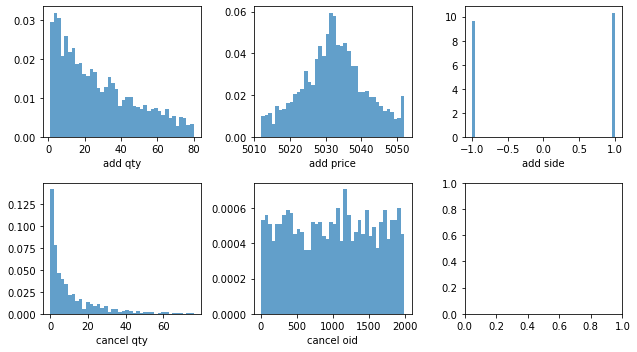

In [8]:
# how many add orders to generate
n_rounds = 2000
# how many cancel orders to generate afterwards
n_cancel = 1500

# distriibution parameters
seed=0
full_cancel_chance=0.05
price_spread = 10
qty_spread = 40
distribution = 'exp'
# strong cut on price and qty for testing
qty_max=80
actual_price = 5032
min_price,max_price = actual_price-20,actual_price+20

rand_state=np.random.RandomState(seed)
traders=[]
tid2plot = 0

for n in range(1):
    traders.append(
        Trader(tid=n, 
               full_cancel_chance=full_cancel_chance, 
               price_spread=price_spread,
               qty_spread=qty_spread,
               qty_max=qty_max,
               distribution=distribution,
               rand_state=rand_state,
               min_price=min_price, max_price=max_price
               )
    )
    
trader=traders[tid2plot]
vals_add = {}
vals_add['side'] = np.zeros(n_rounds)
vals_add['price'] = np.zeros(n_rounds)
vals_add['qty'] = np.zeros(n_rounds)
#for trader in traders:
for i in range(n_rounds):
    order = trader.gen_add_order(actual_price)
    trader.confirm_add_order(i)
    vals_add['price'][i] = order['price']
    vals_add['qty'][i] = order['qty']
    side = -1 if order['side']=='sell' else 1
    vals_add['side'][i] = side
                
vals_cancel = {}
vals_cancel['oid'] = np.zeros(n_cancel)
vals_cancel['qty'] = np.zeros(n_cancel)
for i in range(n_cancel):
    order = trader.gen_cancel_order()
    trader.confirm_cancel_order(order['oid'],order['qty'])
    vals_cancel['oid'][i] = order['oid']
    vals_cancel['qty'][i] = order['qty']
    
fig, axes = plt.subplots(2,3, figsize=(9,5))
hist_kwargs = dict(alpha=0.7, bins=40, density=True)
axes[0,0].hist(vals_add['qty'], **hist_kwargs)
axes[0,0].set_xlabel('add qty')

axes[0,1].hist(vals_add['price'], **hist_kwargs)
axes[0,1].set_xlabel('add price')

axes[0,2].hist(vals_add['side'], **hist_kwargs)
axes[0,2].set_xlabel('add side')

axes[1,0].hist(vals_cancel['qty'], **hist_kwargs)
axes[1,0].set_xlabel('cancel qty')

axes[1,1].hist(vals_cancel['oid'], **hist_kwargs)
axes[1,1].set_xlabel('cancel oid')
#axes[1,2].hist(vals_add['price'], alpha=0.5)

plt.tight_layout()

# Simulation

In [9]:
class Simulation:
    """
    Implements a trading simulation.
    Traders place orders based on some assumed actual price 
    that random-walks in time.
    
    Time is discretized in 0.01s intervals.
    """
    
    def __init__(self, n_traders=10,
                 start_price=5032,
                 min_price=4032,
                 max_price=6032,
                 seed=0,
                 traders_param=[],
                 log_file='log.csv',
                ):
        """
        Args
        ----
        n_traders: int
            number of traders
        start_price: int
            initial market price
        min_price: int
            minimum valid exchange price
        max_price: int
            maximum valid exchange price
        seed: int
            seed for random generation
        traders_param: list of dict
            statistical parameters of each trader
        """
        
        # unit of time = 0.01s
        self.time = 0
        
        # Initialize traders
        self.traders = []
        for n in range(len(traders_param)):
            self.traders.append(
                Trader(
                    tid=n,
                    full_cancel_chance = traders_param[n]['full_cancel_chance'],
                    price_spread = traders_param[n]['price_spread'],
                    qty_spread = traders_param[n]['qty_spread'],
                    qty_max = traders_param[n]['qty_max'],
                    rand_state = np.random.RandomState(n+seed*len(traders_param)),
                    distribution = traders_param[n]['distribution'],
                    min_price = min_price,
                    max_price = max_price,
                )
            )
            
        # initialize exchange
        self.exchange = Exchange(min_price,max_price)
        
        self.actual_price = start_price
        # keep the actual price as a float to be able to tune the random-walk step
        self._actual_price_float = float(start_price)
        
        self.rand_state = np.random.RandomState((seed+1)*len(self.traders)+seed)
        
        self.act = [start_price]
        
    def evolve_actual_price(self,eps):
        """
        Random-walk the actual price.
        eps: float
            eps should be small enough that the price doesn't 
            change too much over the run.
        """
        d = 2*self.rand_state.randint(2) - 1  
        self._actual_price_float += d * eps
        self.actual_price = round(self._actual_price_float)
        self.act.append(self.actual_price)

    def run(self, length=1000, order_dt=1., cancel_add_ratio=0.05, eps=1.):
        """
        Evolve simulation by [length] time steps.
        
        length: int
            length of the run in discrete 0.01s time steps
        order_dt: int
            place orders approx. every [order_dt] time steps
        cancel_add_ratio: float
            how often to cancel orders relative to adding
        eps: float
            size of random steps of the actual price
        """
                
        for i in range(length): 
            if self.rand_state.rand()<1./order_dt:
                for n in range(len(self.traders)):
                    trader = self.traders[n]

                    if ((self.rand_state.rand() > cancel_add_ratio) 
                        or (not trader.orders)):
                        # place add order
                        add_msg = trader.gen_add_order(self.actual_price)
                        (oid, fill_msgs) = self.exchange.execute_order_add(
                            tid = n,
                            side = add_msg['side'],
                            price = add_msg['price'],
                            qty = add_msg['qty'],
                        )
                        if oid != -1:
                            # obtain order ID if approved by the exchange
                            trader.confirm_add_order(oid)
                            # receive fills, remove fully filled orders
                            if fill_msgs:
                                for n in range(len(self.traders)):
                                    self.traders[n].receive_fills(fill_msgs)
                    else:
                        # place cancel order
                        cancel_msg = trader.gen_cancel_order()
                        (oid,_) = self.exchange.execute_order_cancel(
                            oid = cancel_msg['oid'],
                            qty = cancel_msg['qty']
                        )
                        if oid != -1:
                            trader.confirm_cancel_order( 
                                    cancel_msg['oid'], 
                                    cancel_msg['qty'])
                                        
            self.evolve_actual_price(eps)
            self.time += 1
            self.exchange.time += 1
            
    def __enter__(self):
        self.exchange.__enter__()
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.exchange.__exit__(exc_type, exc_value, traceback)

## Small-scale Simulation tests

In [10]:
start_price = 5032
max_price = 6032
min_price = 4032

# Price/qty generation params
# ---------------------------

# spread in the traders' prices 
price_spread = 1
# spread in the random-walking "actual price"
actual_price_spread = 1.2
# spread in the traders' qty
qty_spread = 2
# max qty to place
qty_max = 100
# distribution to draw random prices/qty from
distribution = 'exp'

# Probabilities of different actions
# ---------------------------

# how often to place orders (~ every order_dt>=1 steps)
order_dt = 1.
# how often to cancel with respect to add
cancel_add_ratio = 0.1
# probabily of complete cancellation over changing qty
full_cancel_chance = 0.5

# seed for the random generator
seed=11

# Simulation params
# ---------------------------

# number of traders
n_traders = 2
# length of simulation in steps
length = 9
# how many intermediate frames to save
nframes = 9

# Plotting the orderbook
# ---------------------------

# max number of orders to show in the orderbook plot
n_orders = 5
# max number of prices
n_prices = 10
# center around
mid_price = 5032

# Output
log_file='log.csv'

#=================================================

# by setting eps like this, by the end of [length] 
# the actual price will have deviation~10 cents
eps = actual_price_spread/sqrt(length)

traders_param = []
for n in range(n_traders):
    traders_param.append(
        dict(
            full_cancel_chance = full_cancel_chance,
            price_spread = price_spread,
            qty_spread = qty_spread,
            distribution = distribution,
            qty_max = qty_max
        )
    )
    
orderbooks = []
titles = []
    
# Run simulation
with Simulation(
    n_traders, 
    start_price, min_price, max_price,
    seed, traders_param, log_file
    ) as sim:
        
    for n in range(nframes):
        sim.run(length//nframes, order_dt, cancel_add_ratio, eps)  
        orderbooks.append(
            convert_orderbook(sim.exchange, n_prices,n_orders,mid_price)
            )
        titles.append('time={}, last oid={}, last fid={}'.
                    format(sim.time-1, sim.exchange.oid, sim.exchange.fid))

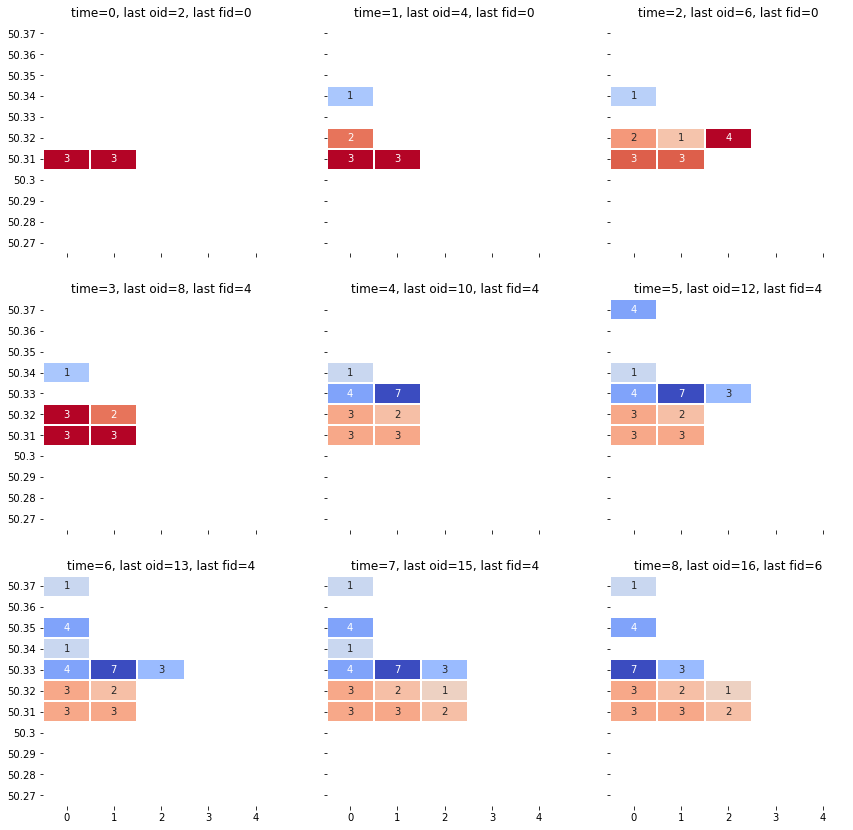

In [11]:
plot_orderbooks(orderbooks, sx=3,sy=3, figscale=1.2, titles=titles, 
                hm_kwargs=dict(annot=True,
                               cbar=False,
                               linewidths=True, 
                               cbar_kws={"shrink": 0.5}))

In [12]:
i0 = 0
log = pd.read_csv('log.csv')
display(log.iloc[i0:i0+40,:])

,time,msg,oid,tid,fid,side,price,qty
0,0,add,,0,,buy,5031,3
1,0,ackn,0,,,,,
2,0,add,,1,,buy,5031,3
3,0,ackn,1,,,,,
4,1,add,,0,,sell,5034,1
5,1,ackn,2,,,,,
6,1,add,,1,,buy,5032,2
7,1,ackn,3,,,,,
8,2,add,,0,,buy,5032,1
9,2,ackn,4,,,,,


Text(0, 0.5, 'Actual price')

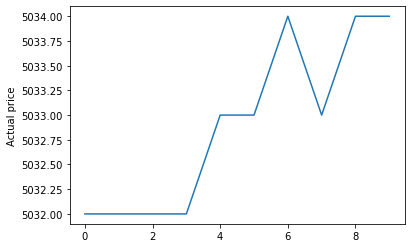

In [13]:
# see the actual price evolution
plt.plot(np.array(sim.act))
plt.ylabel('Actual price')

# Full-scale Simulation Tests 

In [14]:
start_price = 5032
max_price = 6032
min_price = 4032

# Price/qty generation params
# ---------------------------

# spread in the traders' prices 
price_spread = 40
# spread in the random-walking "actual price"
actual_price_spread = 100
# spread in the traders' qty
qty_spread = 30
# max qty to place
qty_max = 90
# distribution to draw random prices/qty from
distribution = 'exp'

# Probabilities of different actions
# ----------------------------------

# how often to place orders (~ every order_dt>=1 steps)
order_dt = 1.
# how often to cancel with respect to add
cancel_add_ratio = 0.05
# probabily of complete cancellation over changing qty
full_cancel_chance = 0.5

# seed for the random generator
seed=1

# Simulation params
# -----------------

# number of traders
n_traders = 10
# length of simulation in steps
length = 1000
# how many intermediate frames to save
nframes = 12

# Plotting params
# ---------------

# max number of orders to show in the orderbook plot
n_orders = 50
# max number of prices
n_prices = 280
# center around
mid_price = 5032

# Output
log_file='log.csv'

#=================================================

# by setting eps like this, by the end of [length] 
# the actual price will have deviation ~ [actual_price_spread]
eps = actual_price_spread / sqrt(length)

traders_param = []
for n in range(n_traders):
    traders_param.append(
        dict(
            full_cancel_chance = full_cancel_chance,
            price_spread = price_spread,
            qty_spread = qty_spread,
            distribution = distribution,
            qty_max = qty_max
        )
    )
    
orderbooks = []
titles = []
    
# Run simulation
with Simulation(
    n_traders, 
    start_price, min_price, max_price,
    seed, traders_param, log_file
    ) as sim:
        
    for n in range(nframes):
        sim.run(length//nframes, order_dt, cancel_add_ratio, eps)  
        # extract orderbook
        orderbooks.append(
            convert_orderbook(sim.exchange, n_prices,n_orders,mid_price)
            )
        titles.append('time={}, last oid={}, last fid={}'.
                    format(sim.time-1, sim.exchange.oid, sim.exchange.fid))

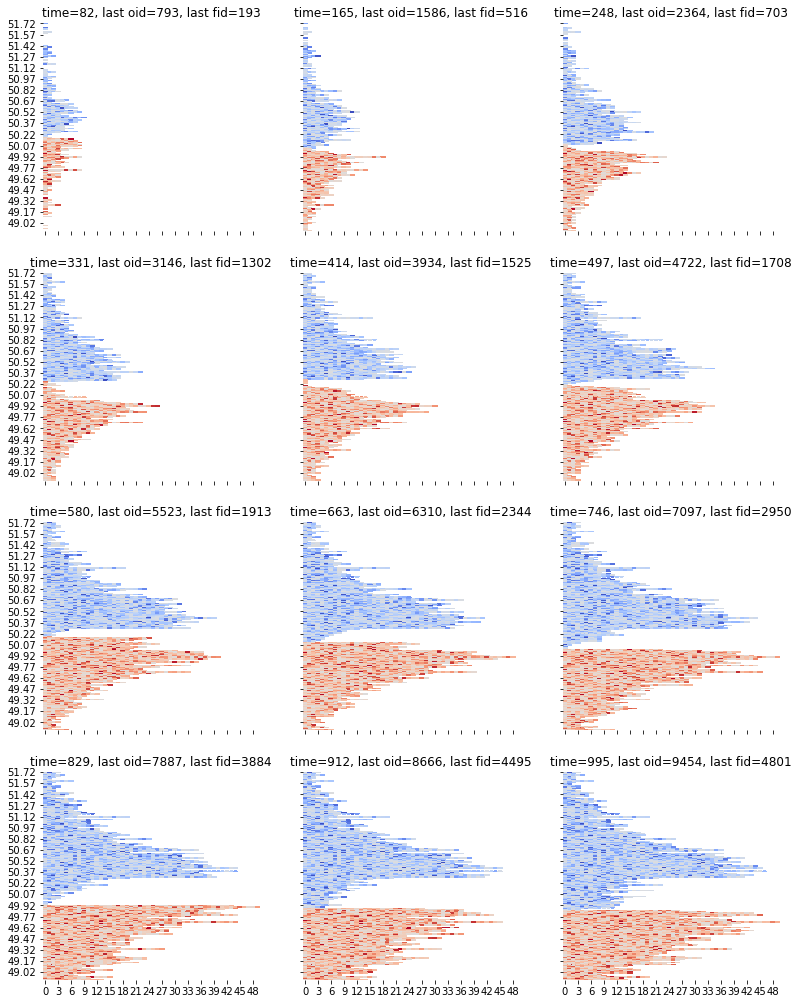

In [15]:
plot_orderbooks(orderbooks, sx=3,sy=4, figscale=1.1, titles=titles, 
                hm_kwargs=dict(annot=False,
                               cbar=False,
                               linewidths=False, 
                               cbar_kws={"shrink": 0.5}))

Text(0, 0.5, 'Actual price')

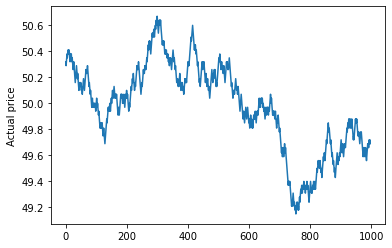

In [16]:
# see the actual price evolution
plt.plot(1e-2*np.array(sim.act))
plt.ylabel('Actual price')

## View logs

In [17]:
i0 = 1000
log = pd.read_csv('log.csv')
display(log.iloc[i0:i0+40,:])

,time,msg,oid,tid,fid,side,price,qty
1000,46,ackn,441,,,,,
1001,46,fill,207,,94,,,15
1002,46,fill,441,,95,,,15
1003,46,add,,5,,sell,5024,35
1004,46,ackn,442,,,,,
1005,46,fill,207,,96,,,2
1006,46,fill,332,,97,,,6
1007,46,fill,7,,98,,,27
1008,46,fill,442,,99,,,35
1009,46,add,,6,,sell,5067,4
